In [1]:
PATH_TO_RESOURCES = "../resources"

In [2]:
import cv2

In [3]:
symbol_files = !ls $PATH_TO_RESOURCES/**/c*.png  | sort
symbol_files

['../resources/train/01/c01_s00.png',
 '../resources/train/01/c04_s01.png',
 '../resources/train/01/c07_s03.png',
 '../resources/train/01/c30_s03.png',
 '../resources/train/01/c34_s03.png',
 '../resources/train/02/c01_s01.png',
 '../resources/train/02/c09_s00.png',
 '../resources/train/02/c14_s05.png',
 '../resources/train/02/c32_s00.png',
 '../resources/train/02/c53_s03.png',
 '../resources/train/03/c03_s04.png',
 '../resources/train/03/c37_s00.png',
 '../resources/train/03/c47_s00.png',
 '../resources/train/03/c50_s01.png',
 '../resources/train/03/c51_s01.png',
 '../resources/train/04/c01_s03.png',
 '../resources/train/04/c22_s05.png',
 '../resources/train/04/c31_s02.png',
 '../resources/train/04/c39_s02.png',
 '../resources/train/04/c46_s04.png',
 '../resources/train/05/c01_s04.png',
 '../resources/train/05/c12_s07.png',
 '../resources/train/05/c23_s01.png',
 '../resources/train/05/c29_s02.png',
 '../resources/train/05/c38_s03.png',
 '../resources/train/06/c01_s05.png',
 '../resourc

In [4]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

In [5]:
symbols = [load_image(symbol_file) for symbol_file in symbol_files]

# Transformateurs

In [6]:
import numpy as np
import matplotlib.pyplot as plt

## Grayscale

On passe les images en niveau de gris.

Nous avons tenté d'utiliser les 3 canaux RGB séparemment pour Fourier mais nous avons eu des complications au niveau de la taille mémoire utilisée.

In [7]:
def to_grayscale(img):
    h,w,_ = img.shape
    result = np.ones((h,w)) * 255
    result[:h,:w] = (np.sum(img, axis=2) / 3) / 255
    
    return result

In [8]:
gray_symbols = []
for symbol in symbols:
    gray_symbols.append(to_grayscale(symbol))

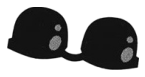

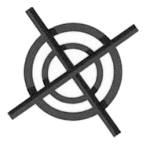

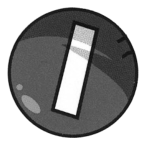

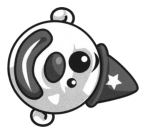

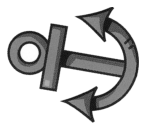

In [9]:
for ii in range(5):
    plt.figure(figsize=(8,16 * 5))
    plt.subplot(1,3,1)
    symbol_index = ii * 5
    plt.imshow(gray_symbols[symbol_index], cmap='gray')
    plt.axis('off')
    plt.show()

### Etape de pipeline

In [10]:
class Grayscale():
    def fit(self, X, y=None, sample_weight=None):
        return self
    
    def to_grayscale(self, img):
        h,w,_ = img.shape
        result = np.ones((h,w)) * 255
        result[:h,:w] = (np.sum(img, axis=2) / 3) / 255

        return result
    
    def transform(self, X, copy=None):
        return [self.to_grayscale(X[i]) for i in range(len(X))]

## Normalisation de la taille des images

### Explications

On veut que toutes les images aient la même taille pour que la transformée de Fourier renvoit toujours le même nombre de valeurs.

On va chercher un cadre capable d'entourer chacune de nos images et on adapte celles-ci pour qu'elles soient contenues ce cadre.

In [11]:
def find_boundig_shape(images):
    max_h, max_w = 0, 0
    i = 0
    for img in images:
        h, w = img.shape
        if h > max_h:
            max_h = h
        
        if w > max_w:
            max_w = w
    
    return (max_h, max_w)

In [12]:
def adapt_to_bounding_shape(image, bounding_shape):
    result = np.ones(bounding_shape)
    
    h, w = image.shape
    b_h, b_w = bounding_shape
    max_h = h if b_h > h else b_h
    max_w = w if b_w > w else b_w
    
    result[:max_h,:max_w] = image[:max_h,:max_w]
    
    return result

In [13]:
bounded_symbols = []
bounding_shape = find_boundig_shape(gray_symbols)
for symbol in gray_symbols:
    bounded = adapt_to_bounding_shape(symbol, bounding_shape)
    bounded_symbols.append(bounded)

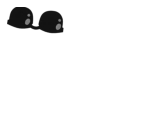

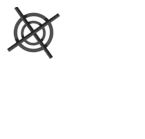

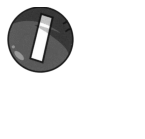

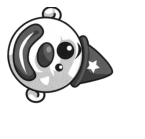

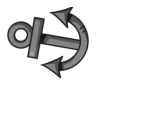

In [14]:
for ii in range(5):
    plt.figure(figsize=(8,16 * 5))
    plt.subplot(1,3,1)
    symbol_index = ii * 5
    plt.imshow(bounded_symbols[symbol_index], cmap='gray')
    plt.axis('off')
    plt.show()

### Etape de pipeline

In [15]:
class BoundaryTransform():
    def fit(self, X, y=None, sample_weight=None):
        max_h, max_w = 0, 0
        for img in X:
            h, w = img.shape
            if h > max_h:
                max_h = h

            if w > max_w:
                max_w = w

        self.bounding_shape = (max_h, max_w)
        
        return self
    
    def adapt_to_bounding_shape(self, image, bounding_shape):
        result = np.ones(bounding_shape)

        h, w = image.shape
        b_h, b_w = bounding_shape
        max_h = h if b_h > h else b_h
        max_w = w if b_w > w else b_w

        result[:max_h,:max_w] = image[:max_h,:max_w]

        return result
    
    def transform(self, X, copy=None):
        bounded = []
        for symbol in X:
            if symbol.shape > self.bounding_shape:
                h_ratio = symbol.shape[0] / self.bounding_shape[0]
                w_ratio = symbol.shape[1] / self.bounding_shape[1]
                scale_fact = 1 / max(h_ratio, w_ratio)
                resized = cv2.resize(symbol, (symbol.shape[0] * scale_fact, symbol.shape[1] * scale_fact))
                bounded.append(self.adapt_to_bounding_shape(resized, self.bounding_shape))
            else:
                bounded.append(self.adapt_to_bounding_shape(symbol, self.bounding_shape))
            
        return np.array(bounded)

## Extraction de la zone d'intérêt

### Explications

Même remarques que pour l'histogramme couleur mais adapté au grayscale.

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
# define a function to compute the mask of a bubble
def symbol2mask(symbol):
    return symbol < 1

In [18]:
symbols_masks = [symbol2mask(symbol) for symbol in bounded_symbols]

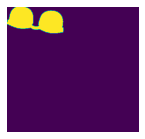

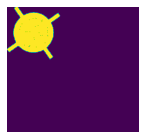

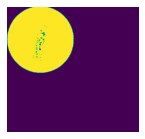

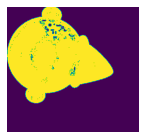

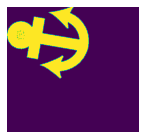

In [19]:
for ii in range(5):
    plt.figure(figsize=(8,16 * 5))
    plt.subplot(1,3,1)
    symbol_index = ii * 5
    plt.imshow(symbols_masks[symbol_index])
    plt.axis('off')
    plt.show()

### Etape de pipeline

In [20]:
class SymbolExtractor():
    def __init__(self):
        self.masks = []
        
    def fit(self, X, y=None, sample_weight=None):
        for symbol in X:
            self.masks.append(symbol < 1)
        
        return self
    
    def transform(self, X, copy=None):
        return [X[i].flatten() for i in range(len(X))]

# Extraction de caractéristiques

## Fourier

### Explications

In [21]:
def fourier_transform(img):
    return np.log(abs(np.fft.fftshift(np.fft.fft2(img))))

In [22]:
fouriers = []
for symbol in bounded_symbols:
    fouriers.append(fourier_transform(symbol))

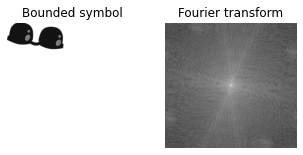

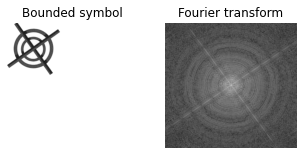

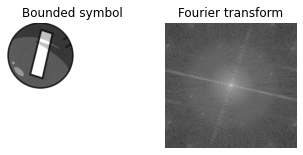

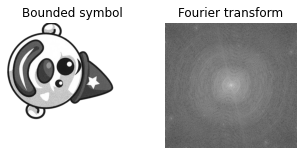

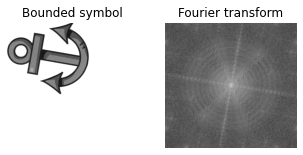

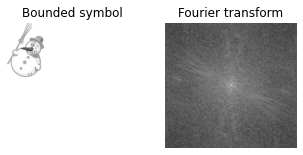

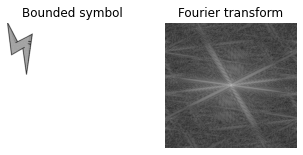

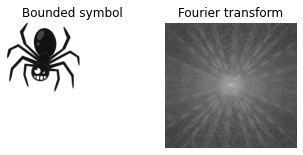

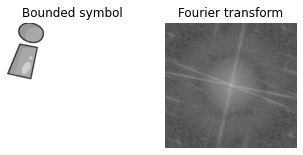

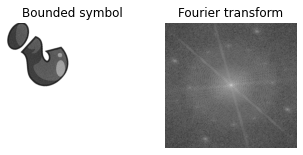

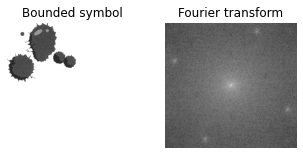

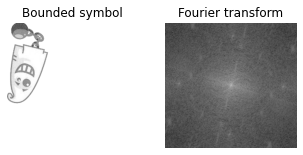

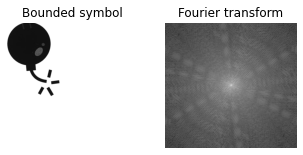

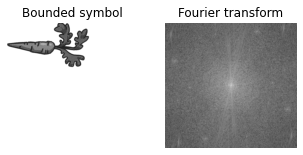

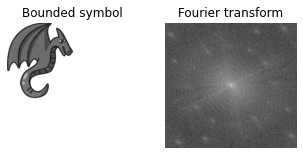

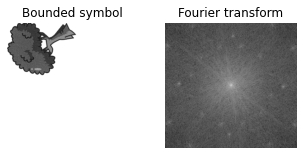

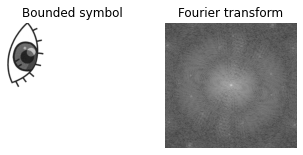

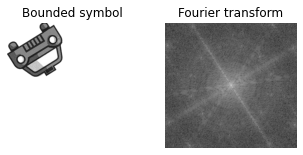

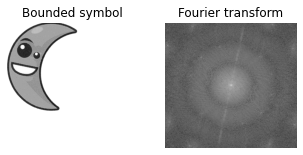

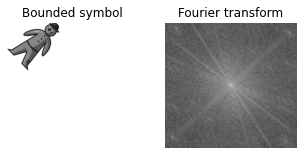

In [23]:
for ii in range(20):
    plt.figure(figsize=(8,4))
    plt.subplot(1,3,1)
    symbol_index = ii * 5
    plt.imshow(bounded_symbols[symbol_index], cmap='gray')
    plt.axis('off'); plt.title("Bounded symbol")
    plt.subplot(1,3,2)
    plt.imshow(fouriers[symbol_index], cmap='gray')
    plt.axis('off'); plt.title("Fourier transform")
    plt.show()

### Etape de pipeline

In [24]:
class FourierTransform():
    def fourier_transform(self, img):
        ft = np.fft.fftshift(np.fft.fft(img))
        return np.log(abs(np.where(ft == 0, np.finfo(float).eps, ft)))

    def fit(self, X, y=None, sample_weight=None):
        
        return self
    
    def transform(self, X, copy=None):
        tmp = [self.fourier_transform(symbol).flatten() for symbol in X]
        maxLen = len(max(tmp, key = lambda e : len(e)))
        results = []
        for res in tmp:
            result = np.ones(maxLen) * np.finfo(np.float32).min
            result[:len(res)] = res
            results.append(result)
        
        return results

# Démonstration

In [25]:
import re

In [26]:
symbols_labels = np.array([re.search(".+/([0-9]{2})/.+\.png", symbol_file).group(1) for symbol_file in symbol_files])

In [27]:
pipeline_transformers = [("grayscale", Grayscale()), ("bound", BoundaryTransform()), ("extract", SymbolExtractor())]

## Classifieur: Dummy classifier

### Démonstration

In [28]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(symbols, symbols_labels, test_size=0.2, stratify=symbols_labels,random_state=42)

In [30]:
steps = pipeline_transformers + [("fourier", FourierTransform()),("clf", SVC())]
pipeline = Pipeline(steps, verbose=True)
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

[Pipeline] ......... (step 1 of 5) Processing grayscale, total=   0.2s
[Pipeline] ............. (step 2 of 5) Processing bound, total=   0.8s
[Pipeline] ........... (step 3 of 5) Processing extract, total=   0.1s
[Pipeline] ........... (step 4 of 5) Processing fourier, total=   3.9s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   8.1s


0.2982456140350877